In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from pandas_datareader import data as wb
import datetime
import requests
from scipy.stats.mstats import gmean
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer



In [2]:
start_time = datetime.datetime.now() # Замер времени выполнения скрипта для одного тикера

In [3]:
COMPANY = 'AAPL'
KEY = '2105b9f242d47b69fc73f0f2205be048'
finwiz_url = 'https://finviz.com/quote.ashx?t='

In [4]:
IS = requests.get(f'https://financialmodelingprep.com/api/v3/income-statement/{COMPANY}?apikey={KEY}').json()
FIS = requests.get(f'https://financialmodelingprep.com/api/v3/financials/income-statement/{COMPANY}?apikey={KEY}').json()
BL = requests.get(f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{COMPANY}?apikey={KEY}').json()
RT = requests.get(f'https://financialmodelingprep.com/api/v3/ratios/{COMPANY}?apikey={KEY}').json()
CF = requests.get(f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{COMPANY}?apikey={KEY}').json()
EV = requests.get(f'https://financialmodelingprep.com/api/v3/enterprise-values/{COMPANY}?apikey={KEY}').json()
PF = requests.get(f'https://financialmodelingprep.com/api/v3/profile/{COMPANY}?apikey={KEY}').json()
CQ = requests.get(f'https://financialmodelingprep.com/api/v3/quote/{COMPANY}?apikey={KEY}').json()
FS = requests.get(f'https://financialmodelingprep.com/api/v3/financial-statement-full-as-reported/{COMPANY}?apikey={KEY}').json()
KM = requests.get(f'https://financialmodelingprep.com/api/v3/key-metrics/{COMPANY}?apikey={KEY}').json()

In [5]:
    financial_income_statement = pd.DataFrame(FIS['financials'])
    income_statement = pd.DataFrame(IS)
    balance = pd.DataFrame(BL)
    ratios = pd.DataFrame(RT)
    cash_flow = pd.DataFrame(CF)
    enterprise_value = pd.DataFrame(EV)
    company_profile = pd.DataFrame(PF)
    real_time_quote = pd.DataFrame(CQ)
    financial_statement = pd.DataFrame(FS)
    key_metrics = pd.DataFrame(KM)

In [6]:
LTGrowth = 0.02
LTdis = 0.08
PRICE = real_time_quote['price'][0]
company_profile_beta = company_profile['beta']
Total_rating = []

In [7]:
work_table = pd.concat(
        (income_statement[['date', 'revenue', 'operatingIncome', 'netIncome', 'eps', 'ebitda',
                          'depreciationAndAmortization', 'interestExpense', 'incomeBeforeTax',
                               'incomeTaxExpense', 'researchAndDevelopmentExpenses', 'generalAndAdministrativeExpenses',
                          'sellingAndMarketingExpenses', 'otherExpenses', 'operatingExpenses', 'costAndExpenses',
                          ]].replace(np.nan, 0)[0:10],
        balance[['totalAssets', 'totalLiabilities', 'totalStockholdersEquity',
                        'totalDebt', 'netDebt']].replace(np.nan, 0)[0:10],
        ratios[['dividendPayoutRatio', 'dividendYield', 'effectiveTaxRate', 'payoutRatio']].replace(
            np.nan, 0)[0:10],
        cash_flow[['freeCashFlow', 'dividendsPaid']].replace(np.nan, 0)[0:10],
        enterprise_value[['numberOfShares', 'stockPrice']].replace(np.nan, 0)[0:10],
        key_metrics[['debtToEquity', 'bookValuePerShare', 'roe', 'currentRatio']].replace(np.nan,
                                                                                          0)[0:10],
        financial_income_statement['Dividend per Share'].replace(np.nan, 0)[0:10],
        company_profile['mktCap'].replace(np.nan, 0)[0:10]

        ),axis=1)

In [8]:
print(work_table)

         date       revenue  operatingIncome    netIncome      eps  \
0  2019-09-28  260174000000     6.393000e+10  55256000000  2.97145   
1  2018-09-29  265595000000     7.089800e+10  59531000000  3.05148   
2  2017-09-30  229234000000     6.134400e+10  48351000000  2.30169   
3  2016-09-24  215639000000     6.002400e+10  45687000000  2.07658   
4  2015-09-26  233715000000     7.123000e+10  53394000000  2.30422   
5  2014-09-27  182795000000     5.250300e+10  39510000000  6.45000   
6  2013-09-28  170910000000     4.899900e+10  37037000000  5.68000   
7  2012-09-29  156508000000     5.524100e+10  41733000000  6.31000   
8  2011-09-24  108249000000     3.379000e+10  25922000000  3.95000   
9  2010-09-25   65225000000     1.838500e+10  14013000000  2.16000   

        ebitda  depreciationAndAmortization  interestExpense  incomeBeforeTax  \
0  81860000000                 1.254700e+10     3.576000e+09      65737000000   
1  85546000000                 1.090300e+10     3.240000e+09      7

Расчет показателей качества

In [9]:
# считаем рост выручки______________________________________________________________
revenue_growth = round((((work_table['revenue'][0]/work_table['revenue'][9]) ** 0.1) -1), 2)

print(f'revenue_growth {revenue_growth}')


if revenue_growth >= 0.05:
    revenue_growth_rating = 1
elif 0.05 > revenue_growth > 0.02:
    revenue_growth_rating = 0
else:
    revenue_growth_rating = -1

Total_rating.append(revenue_growth_rating)

# считаем Использование прибыли______________________________________________________________
average_dividend_payout_percentage = np.mean(work_table['dividendYield'][0:])

# average_percentage_of_buyback  # не найден   !!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

SHAREHOLDERS_EQUITY = (work_table['totalAssets'] - work_table['totalLiabilities'])

average_quity_SHAREHOLDERS_EQUITY = round((((SHAREHOLDERS_EQUITY[0] / SHAREHOLDERS_EQUITY[9]) ** 0.1) -1), 2)

use_of_profit = round((average_dividend_payout_percentage + average_quity_SHAREHOLDERS_EQUITY), 2)

print(f'use_of_profit {use_of_profit}')

if use_of_profit < 0.06:
    use_of_profit_rating = -2
elif 0.1 < use_of_profit > 0.06:
    use_of_profit_rating = 0
else:
    use_of_profit_rating = 2

Total_rating.append(use_of_profit_rating)

# Считаем Операционную маржу_________________________________________________________________

OPERATING_MAR = work_table['operatingIncome']/work_table['revenue']

operating_margin = round(np.mean(OPERATING_MAR[0:]), 2)

print(f'operating_margin {operating_margin}')

if operating_margin < 0.06:
    operating_margin_rating = -2
elif 0.14 > operating_margin > 0.06:
    operating_margin_rating = 0
else:
    operating_margin_rating = 2

Total_rating.append(operating_margin_rating)

# Считаем Динамику операционной маржи_________________________________________________________________

if OPERATING_MAR.std() < 0.1:
    operating_margin_dynamics = 'Рост'
    operating_margin_dynamics_rating = 2
else:
    operating_margin_dynamics = 'Падение'
    operating_margin_dynamics_rating = -2

Total_rating.append(operating_margin_dynamics_rating)

print(f'operating_margin_dynamics {operating_margin_dynamics}')

# Считаем Маржу чистой прибыли_________________________________________________________________

NET_PROFIT_MAR = work_table['netIncome']/work_table['revenue']

net_profit_margin = round(np.mean(NET_PROFIT_MAR[0:]), 2)

print(f'net_profit_margin {net_profit_margin}')

if net_profit_margin < 0.06:
    net_profit_margin_rating = -2
elif 0.1 > net_profit_margin > 0.06:
    net_profit_margin_rating = 0
else:
    net_profit_margin_rating = 2

Total_rating.append(net_profit_margin_rating)

# Считаем Динамику маржи чистой прибыли_________________________________________________________________

if NET_PROFIT_MAR.std() < 0.1 :
    net_profit_margin_dynamics = 'Рост'
    net_profit_margin_dynamics_rating = 1
else:
    net_profit_margin_dynamics = 'Падение'
    net_profit_margin_dynamics_rating = -1

Total_rating.append(net_profit_margin_dynamics_rating)

print(f'net_profit_margin_dynamics {net_profit_margin_dynamics}')

# Считаем Рост EPS_________________________________________________________________

EPS_growth = round((((work_table['eps'][0]/work_table['eps'][9]) ** 0.1) -1), 2)   # Первый вариант, eps - берем из API

# EPS_growth = round((((SHAREHOLDERS_EQUITY[0] / SHAREHOLDERS_EQUITY[9]) ** 0.1) -1), 2)  # Второй вариант, eps = totalAssets - totalLiabilities

#  !!!!!!!!!!!!!!!!!При разных вариантах разные значения!!!!!!!!!!!!!!!!!!!!!!

print(f'EPS_growth {EPS_growth}')

if EPS_growth < 0.06:
    EPS_growth_rating = -2
elif 0.1 > EPS_growth > 0.06:
    EPS_growth_rating = 0
else:
    EPS_growth_rating = 2

Total_rating.append(EPS_growth_rating)

# Считаем Уровень долга_________________________________________________________________

debt_level = round(np.mean(work_table['totalLiabilities']/work_table['totalAssets']), 2)

print(f'debt_level {debt_level}')

if debt_level < 0.5:
    debt_level_rating = 1
elif 0.7 > debt_level > 0.5:
    debt_level_rating = 0
else:
    debt_level_rating = -1

Total_rating.append(debt_level_rating)

 # ___________________________________ ROE_DuPont _______________________________________________

Profitability = []
TechnicalEfficiency = []
FinancialStructure = []

for year in range(0, 10):
    last_year = year + 1
    Profitability.append(work_table['netIncome'][year] / work_table['revenue'][year])
    TechnicalEfficiency.append(work_table['revenue'][year] / (
            (work_table['totalAssets'][year] + balance['totalAssets'].replace(np.nan, 0)[last_year]) / 2))
    FinancialStructure.append(((work_table['totalAssets'][year] + balance['totalAssets'].replace(np.nan, 0)[last_year]) / 2) /
                                      ((work_table['totalStockholdersEquity'][year] +
                                        balance['totalStockholdersEquity'].replace(np.nan, 0)[last_year]) / 2))

work_table['Profitability'] = Profitability
work_table['TechnicalEfficiency'] = TechnicalEfficiency
work_table['FinancialStructure'] = FinancialStructure

work_table['ROE_DuPont'] = work_table['FinancialStructure'] * work_table['TechnicalEfficiency'] * \
                                   work_table['Profitability']

ROE_DuPont = round(work_table['ROE_DuPont'].mean(axis=0), 5)
decomp = work_table[['date', 'Profitability', 'TechnicalEfficiency', 'FinancialStructure', 'ROE_DuPont']]

print(f'ROE_DuPont_average {ROE_DuPont}')
print(decomp)

if ROE_DuPont < 0.08:
    ROE_average_rating = -2
elif 0.14 > ROE_DuPont > 0.08:
    ROE_average_rating = 0
else:
    ROE_average_rating = 2

Total_rating.append(ROE_average_rating)

# Считаем ROA_________________________________________________________________

ROA_average = round(np.mean(work_table['netIncome']/work_table['totalAssets']), 2)

print(f'ROA_average {ROA_average}')

if ROA_average < 0.06:
    ROA_average_rating = -1
elif 0.08 > ROA_average > 0.06:
    ROA_average_rating = 0
else:
    ROA_average_rating = 1

Total_rating.append(ROA_average_rating)

# Получаем общую оценку_________________________________________________________________

print(Total_rating)
print(f'Общая оценка = {sum(Total_rating)}')

revenue_growth 0.15
use_of_profit 0.09
operating_margin 0.29
operating_margin_dynamics Рост
net_profit_margin 0.22
net_profit_margin_dynamics Рост
EPS_growth 0.03
debt_level 0.52
ROE_DuPont_average 0.40935
         date  Profitability  TechnicalEfficiency  FinancialStructure  \
0  2019-09-28       0.212381             0.738878            3.563342   
1  2018-09-29       0.224142             0.716813            3.072398   
2  2017-09-30       0.210924             0.657769            2.657322   
3  2016-09-24       0.211868             0.704667            2.471814   
4  2015-09-26       0.228458             0.895144            2.261496   
5  2014-09-27       0.216144             0.833085            1.866637   
6  2013-09-28       0.216705             0.892331            1.584487   
7  2012-09-29       0.266651             1.070378            1.501014   
8  2011-09-24       0.239466             1.130219            1.539749   
9  2010-09-25       0.214841             1.063301            1.5

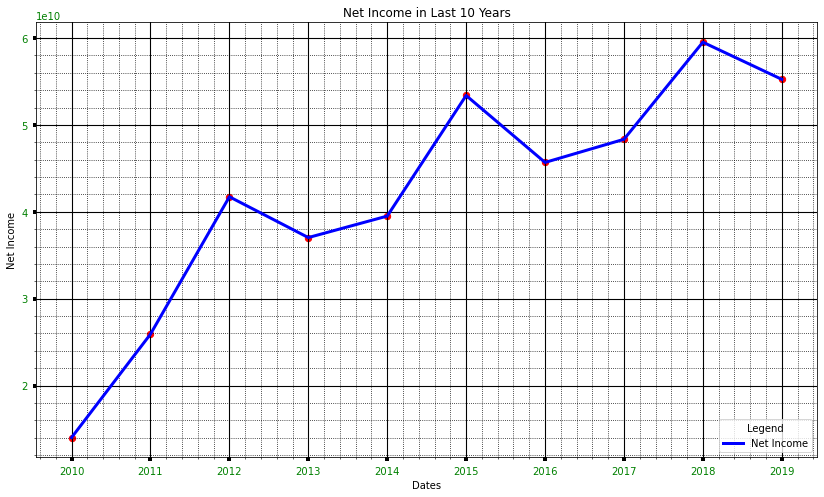

In [10]:
plot_date = pd.to_datetime(work_table['date'], format='%Y-%m-%d').dt.year 

plt.figure(figsize=(14,8))   

netIncome_plot = plt.plot(plot_date[::-1], work_table['netIncome'][::-1], label='Net Income', color='b')
plt.scatter(plot_date[::-1], work_table['netIncome'][::-1], color='r', s = 40)
plt.setp(netIncome_plot, linewidth=3, alpha=1)
plt.xlabel('Dates')
plt.ylabel('Net Income')
plt.legend(loc='lower right', title='Legend')
plt.title('Net Income in Last 10 Years')


plt.grid(color='black', which='major', linewidth=1.1)
plt.minorticks_on()
plt.grid(color='black', linestyle = ':', linewidth=0.8, which='minor')


plt.xticks(plot_date[::-1])
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               width = 4,     #  Ширина делений
               color = 'black',    #  Цвет делений
               pad = 5,    #  Расстояние между черточкой и ее подписью
               labelsize = 10,    #  Размер подписи
               labelcolor = 'green',    #  Цвет подписи
               labelbottom = True,    #  Рисуем подписи снизу
               labelleft = True,    #  слева
               labelrotation = 0)         #  Поворот подписей         


                             

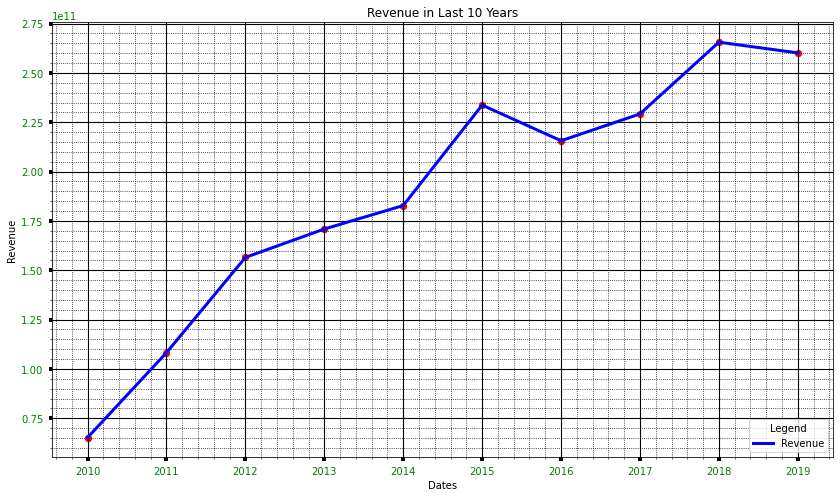

In [11]:
plt.figure(figsize=(14,8))   

netIncome_plot = plt.plot(plot_date[::-1], work_table['revenue'][::-1], label='Revenue', color='b')
plt.scatter(plot_date[::-1], work_table['revenue'][::-1], color='r', s = 40)
plt.setp(netIncome_plot, linewidth=3, alpha=1)
plt.xlabel('Dates')
plt.ylabel('Revenue')
plt.legend(loc='lower right', title='Legend')
plt.title('Revenue in Last 10 Years')


plt.grid(color='black', which='major', linewidth=1.1)
plt.minorticks_on()
plt.grid(color='black', linestyle = ':', linewidth=0.8, which='minor')


plt.xticks(plot_date[::-1])
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               width = 4,     #  Ширина делений
               color = 'black',    #  Цвет делений
               pad = 5,    #  Расстояние между черточкой и ее подписью
               labelsize = 10,    #  Размер подписи
               labelcolor = 'green',    #  Цвет подписи
               labelbottom = True,    #  Рисуем подписи снизу
               labelleft = True,    #  слева
               labelrotation = 0)         #  Поворот подписей         

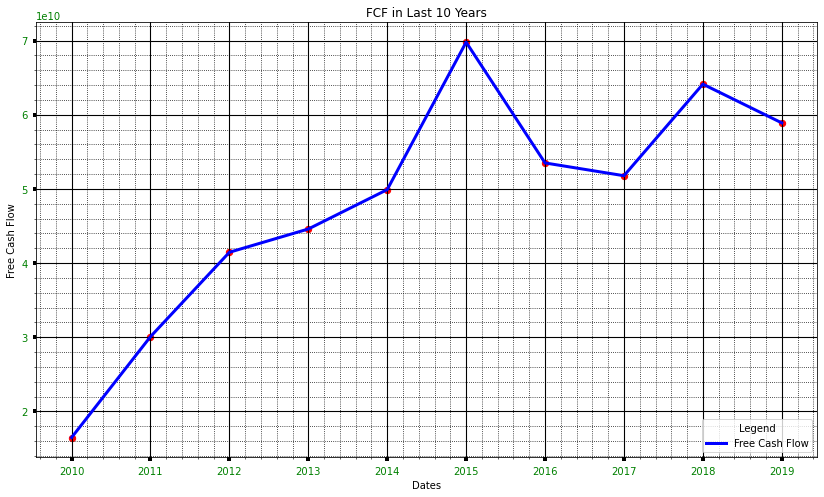

In [12]:
plt.figure(figsize=(14,8))   

netIncome_plot = plt.plot(plot_date[::-1], work_table['freeCashFlow'][::-1], label='Free Cash Flow', color='b')
plt.scatter(plot_date[::-1], work_table['freeCashFlow'][::-1], color='r', s = 40)
plt.setp(netIncome_plot, linewidth=3, alpha=1)
plt.xlabel('Dates')
plt.ylabel('Free Cash Flow')
plt.legend(loc='lower right', title='Legend')
plt.title('FCF in Last 10 Years')


plt.grid(color='black', which='major', linewidth=1.1)
plt.minorticks_on()
plt.grid(color='black', linestyle = ':', linewidth=0.8, which='minor')


plt.xticks(plot_date[::-1])
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               width = 4,     #  Ширина делений
               color = 'black',    #  Цвет делений
               pad = 5,    #  Расстояние между черточкой и ее подписью
               labelsize = 10,    #  Размер подписи
               labelcolor = 'green',    #  Цвет подписи
               labelbottom = True,    #  Рисуем подписи снизу
               labelleft = True,    #  слева
               labelrotation = 0)         #  Поворот подписей    

# Оцениваем инвестиционную стоимость  

In [13]:
print('Считаем инвестиционную стоимость по дивидендной модели Гордона')

Dtoday =   work_table['dividendsPaid'][0] / work_table['numberOfShares'][0]

# ROE and PAyout Ratio

ROE_formul = ROE_DuPont
print(f'ROE_formul {ROE_formul}')

payout_ratio = work_table['payoutRatio'].median(axis = 0)
sustgrwothrate = ROE_formul * (1 - payout_ratio)
print(f'payout_ratio {payout_ratio}')
print(f'sustgrwothrate {sustgrwothrate}')

##Cost of equity:
# Risk Free Rate
start = datetime.datetime(2019, 2, 1)
end= datetime.datetime.today().strftime('%Y-%m-%d')
#end = datetime.datetime(2020, 2, 27)

Treasury = wb.DataReader(['DGS10'], 'fred', start, end)
RF = float(Treasury.iloc[-1])
RF = RF / 100
print(f'RF {RF}')

# Beta
beta = float(company_profile_beta)
print(f'beta {beta}')

# Market Return
# Считаем годовую доходность
data = wb.DataReader('^GSPC', data_source='yahoo', start='2001-1-1') # нужно определиться с переменной
data['simple_return'] = (data['Adj Close'] / data['Adj Close'].shift(1)) - 1
data['simple_return'].replace(np.nan, 0)
avg_returns_a = data['simple_return'].mean() * 250

print(f'Годовая доходность S&P500 {avg_returns_a*100}')

# Drop all Not a number values using drop method.
ke = RF + (beta * (avg_returns_a - RF))
print(f'Стоимость капитала {ke*100}')

DDM = (Dtoday * (1 + sustgrwothrate)) / (ke - sustgrwothrate)

print(f'Расчетная стоимость по модели Гордона {DDM}')

print(f'Время выполнения :{datetime.datetime.now() - start_time}') # Замер времени

Считаем инвестиционную стоимость по дивидендной модели Гордона
ROE_formul 0.40935
payout_ratio 0.24292676911980995
sustgrwothrate 0.3099079270608058
RF 0.0069
beta 1.34434
Годовая доходность S&P500 6.823745883299212
Стоимость капитала 8.935839940754462
Расчетная стоимость по модели Гордона 4.509487281509314
Время выполнения :0:00:12.506407


# Расчет методом дисконтирования FCF спрогнозируемого методом линейной регрессии

In [14]:
# 'year_index' as the order of the year
work_table['year_index'] = range(1, len(work_table) + 1)[::-1]
# add intercept
work_table['intercept'] = 1

print(work_table)


# modeling
freeCashFlow_model = sm.OLS(work_table['freeCashFlow'], work_table[['year_index','intercept']]).fit()


freeCashFlow_pred_lr = freeCashFlow_model.predict([19,1])[0] #Прогнозируем через 10 лет


freeCashFlow_pred_lr5 = freeCashFlow_model.predict([14,1])[0] #Прогнозируем через 5 лет
freeCashFlow_pred_lr4 = freeCashFlow_model.predict([13,1])[0]
freeCashFlow_pred_lr3 = freeCashFlow_model.predict([12,1])[0]
freeCashFlow_pred_lr2 = freeCashFlow_model.predict([11,1])[0]
freeCashFlow_pred_lr1 = freeCashFlow_model.predict([10,1])[0]


# CAGR FCF

CF_forecast = {}

CF_forecast['next_year1'] = {}
CF_forecast['next_year1']['freeCashFlow'] = freeCashFlow_pred_lr1

CF_forecast['next_year2'] = {}
CF_forecast['next_year2']['freeCashFlow'] = freeCashFlow_pred_lr2

CF_forecast['next_year3'] = {}
CF_forecast['next_year3']['freeCashFlow'] = freeCashFlow_pred_lr3

CF_forecast['next_year4'] = {}
CF_forecast['next_year4']['freeCashFlow'] = freeCashFlow_pred_lr4

CF_forecast['next_year5'] = {}
CF_forecast['next_year5']['freeCashFlow'] = freeCashFlow_pred_lr5

print(CF_forecast)

print(f'freeCashFlow_pred_lr1 = {freeCashFlow_pred_lr1}')
print(f'freeCashFlow_pred_lr2 = {freeCashFlow_pred_lr2}')
print(f'freeCashFlow_pred_lr3 = {freeCashFlow_pred_lr3}')
print(f'freeCashFlow_pred_lr4 = {freeCashFlow_pred_lr4}')
print(f'freeCashFlow_pred_lr5 = {freeCashFlow_pred_lr5}')



print(freeCashFlow_pred_lr)


# ________________________________________  Расчет WACC  _______________________________________________


WACC = (work_table['mktCap'][0] / (work_table['mktCap'][0] + work_table['netDebt'][0:2].mean())) * ke + (
                work_table['netDebt'][0:2].mean() / (work_table['mktCap'][0] + work_table['netDebt'][0:2].mean())) * (
                        work_table['interestExpense'][0] / work_table['netDebt'][0:2].mean()) \
               * (1 - (work_table['incomeTaxExpense'][0] / work_table['incomeBeforeTax'][0]))

print(f'WACC {WACC}')
print(f'''mktCap {work_table['mktCap'][0]}''')
print(f'''netDebt {work_table['netDebt'][0:2].mean()}''')
print(f'''interestExpense {work_table['interestExpense'][0]}''')
print(f'''incomeTaxExpense {work_table['incomeTaxExpense'][0]}''')
print(f'''incomeBeforeTax {work_table['incomeBeforeTax'][0]}''')

wacc_company = WACC

print('wacc of = ' + COMPANY + ' is \n' + str((wacc_company * 100)) + '%')

CF_forec = pd.DataFrame.from_dict(CF_forecast, orient='columns')

FCF_List = CF_forec.iloc[0:].values.tolist()

npv = npf.npv(wacc_company, FCF_List[0])
print(f'npv = {npv}')

Terminal_value_Discounted = freeCashFlow_pred_lr * (1 + LTGrowth) / (LTdis - LTGrowth)

print(f'Terminal_value_Discounted = {Terminal_value_Discounted}')

sum_num = npv + Terminal_value_Discounted
print(f'sum_num = {sum_num}')

spl_num = sum_num / work_table['numberOfShares'][0]
print(f'Estimated price = {spl_num}')

difference_model_and_market_value = spl_num - PRICE
print(f'stock price = {PRICE}')

print(f'difference_model_and_market_value = {difference_model_and_market_value}')

         date       revenue  operatingIncome    netIncome      eps  \
0  2019-09-28  260174000000     6.393000e+10  55256000000  2.97145   
1  2018-09-29  265595000000     7.089800e+10  59531000000  3.05148   
2  2017-09-30  229234000000     6.134400e+10  48351000000  2.30169   
3  2016-09-24  215639000000     6.002400e+10  45687000000  2.07658   
4  2015-09-26  233715000000     7.123000e+10  53394000000  2.30422   
5  2014-09-27  182795000000     5.250300e+10  39510000000  6.45000   
6  2013-09-28  170910000000     4.899900e+10  37037000000  5.68000   
7  2012-09-29  156508000000     5.524100e+10  41733000000  6.31000   
8  2011-09-24  108249000000     3.379000e+10  25922000000  3.95000   
9  2010-09-25   65225000000     1.838500e+10  14013000000  2.16000   

        ebitda  depreciationAndAmortization  interestExpense  incomeBeforeTax  \
0  81860000000                 1.254700e+10     3.576000e+09      65737000000   
1  85546000000                 1.090300e+10     3.240000e+09      7

# Стоимость акции по дивам и балансовой стоимости(линейная регрессия)

In [15]:
dvd_avg = np.mean((work_table['Dividend per Share']).astype(float))  # Определим средний дивиденд
print(dvd_avg)


2.820331467201


In [16]:
start = datetime.datetime(1999, 12, 31)
end= datetime.datetime.today().strftime('%Y-%m-%d')
Treasury = wb.DataReader(['DGS10'], 'fred', start, end)
RF = float(Treasury.iloc[-1])
risk_free_rate = RF/100
# The discounted capital for the dividend of 3-year later
dvd_avg / (1 + risk_free_rate) ** 3
# The discounted capital for the dividend of 10-year later
# dvd_avg/(1+risk_free_rate)**10

2.7627470916494725

In [17]:
dvd_total = 0
for j in range(1, 11):
    dvd_total = dvd_total + dvd_avg / (1 + risk_free_rate) ** j
print(dvd_total)

27.16188972670934


In [18]:
growth_rate_of_10y = (work_table['bookValuePerShare'][0]) / (work_table['bookValuePerShare'][9])
avg_growth_rate = growth_rate_of_10y ** (1 / 10)
print(avg_growth_rate)

1.101792738957582


In [19]:
bvps_pred = (work_table['bookValuePerShare'][0]) * (avg_growth_rate ** 10)
print(bvps_pred)

12.828581534090501


In [20]:
data_intrinsic = bvps_pred + dvd_total
print(data_intrinsic)

39.99047126079984


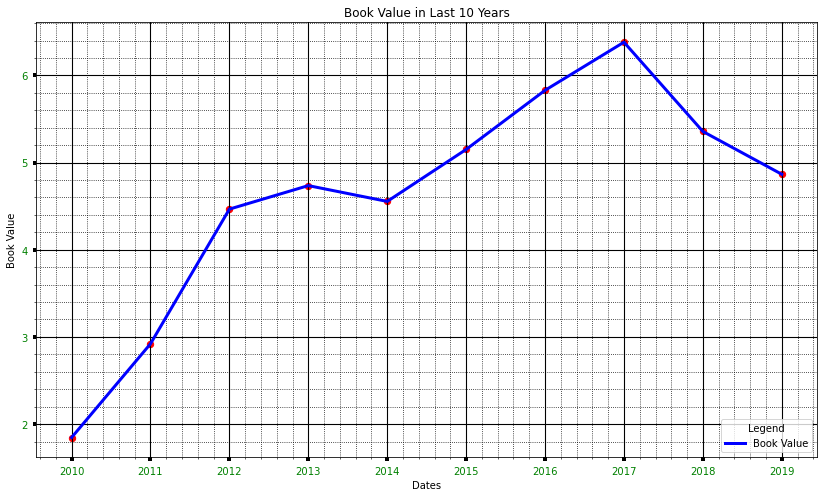

In [21]:
plt.figure(figsize=(14,8))   

netIncome_plot = plt.plot(plot_date[::-1], work_table['bookValuePerShare'][::-1], label='Book Value', color='b')
plt.scatter(plot_date[::-1], work_table['bookValuePerShare'][::-1], color='r', s = 40)
plt.setp(netIncome_plot, linewidth=3, alpha=1)
plt.xlabel('Dates')
plt.ylabel('Book Value')
plt.legend(loc='lower right', title='Legend')
plt.title('Book Value in Last 10 Years')


plt.grid(color='black', which='major', linewidth=1.1)
plt.minorticks_on()
plt.grid(color='black', linestyle = ':', linewidth=0.8, which='minor')


plt.xticks(plot_date[::-1])
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               width = 4,     #  Ширина делений
               color = 'black',    #  Цвет делений
               pad = 5,    #  Расстояние между черточкой и ее подписью
               labelsize = 10,    #  Размер подписи
               labelcolor = 'green',    #  Цвет подписи
               labelbottom = True,    #  Рисуем подписи снизу
               labelleft = True,    #  слева
               labelrotation = 0)         #  Поворот подписей  

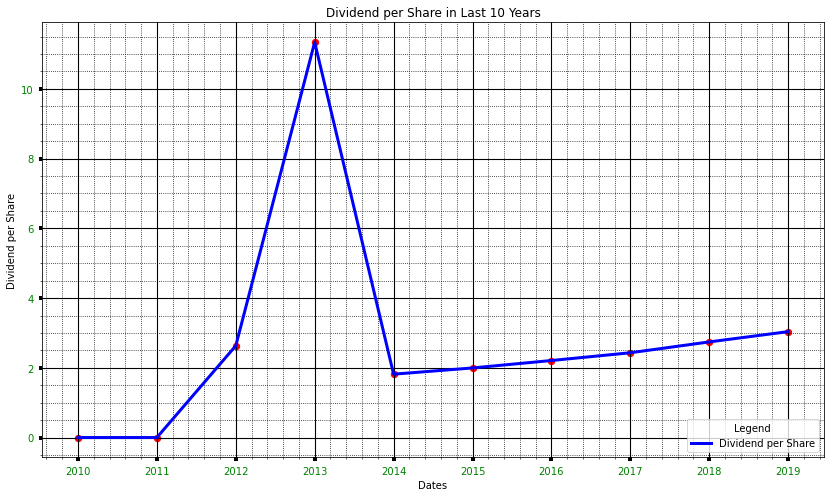

In [22]:
plt.figure(figsize=(14,8))   

netIncome_plot = plt.plot(plot_date[::-1], work_table['Dividend per Share'][::-1].astype('float'), 
                          label='Dividend per Share', color='b')
plt.scatter(plot_date[::-1], work_table['Dividend per Share'][::-1].astype('float'), color='r', s = 40)
plt.setp(netIncome_plot, linewidth=3, alpha=1)
plt.xlabel('Dates')
plt.ylabel('Dividend per Share')
plt.legend(loc='lower right', title='Legend')
plt.title('Dividend per Share in Last 10 Years')


plt.grid(color='black', which='major', linewidth=1.1)
plt.minorticks_on()
plt.grid(color='black', linestyle = ':', linewidth=0.8, which='minor')


plt.xticks(plot_date[::-1])
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               width = 4,     #  Ширина делений
               color = 'black',    #  Цвет делений
               pad = 5,    #  Расстояние между черточкой и ее подписью
               labelsize = 10,    #  Размер подписи
               labelcolor = 'green',    #  Цвет подписи
               labelbottom = True,    #  Рисуем подписи снизу
               labelleft = True,    #  слева
               labelrotation = 0)         #  Поворот подписей  


In [23]:
# 'year_index' as the order of the year
work_table['year_index'] = range(1, len(work_table) + 1)[::-1]
# add intercept
work_table['intercept'] = 1

In [24]:
# modeling
bvps_model = sm.OLS(work_table['bookValuePerShare'], work_table[['year_index', 'intercept']]).fit()

In [25]:
bvps_pred_lr = bvps_model.predict([19, 1])[0]  # Прогнозируем балансовую стоимость через 10 лет
print(f'bvps_pred_lr через 10 лет: {bvps_pred_lr}' )

bvps_pred_lr через 10 лет: 9.330608022187818


In [26]:
dvd_model = sm.OLS((work_table['Dividend per Share']).astype(float), work_table[['year_index', 'intercept']]).fit()

dvd_model.predict([19, 1])[0]  # Определить дивиденд через 10 лет

4.318963009097454

In [27]:
# Дивиденды за 10 лет
dvd_total_lr = 0
current_year_order = 9
for j in range(1, 11):
    dvd_new = dvd_model.predict([current_year_order + j, 1])[0]
    dvd_total_lr = dvd_total_lr + dvd_new / (1 + risk_free_rate) ** j
print(f'dvd_total_lr: {dvd_total_lr}' )

dvd_total_lr: 36.72320227139367


In [28]:
aapl_intrinsic_lr = dvd_total_lr + bvps_pred_lr
print(f'aapl_intrinsic_lr: {aapl_intrinsic_lr}' )

aapl_intrinsic_lr: 46.053810293581485


In [29]:
difference_model_and_market_value = aapl_intrinsic_lr - PRICE
print(f'stock price = {PRICE}')
print(f'difference_model_and_market_value = {difference_model_and_market_value}')

stock price = 116.79
difference_model_and_market_value = -70.73618970641851


# Оценка дисперсии модели линейной регресси дивов через R-Squared

0    3.03705403822
1    2.74234021698
2    2.43140686849
3    2.20897805039
4    1.99566067658
5      1.817183144
6     11.338876116
7    2.63181556135
8              0.0
9              0.0
Name: Dividend per Share, dtype: object
           y   x
0   3.037054  10
1   2.742340   9
2   2.431407   8
3   2.208978   7
4   1.995661   6
5   1.817183   5
6  11.338876   4
7   2.631816   3
8   0.000000   2
9   0.000000   1


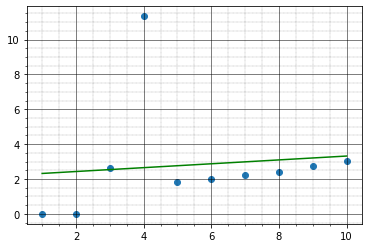

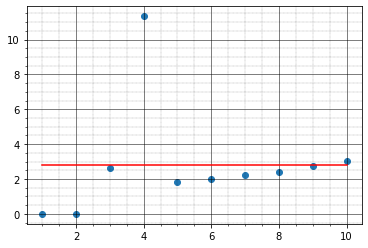

90.77413547298275
The rsquared value is: 0.011199896986532787


In [30]:
# # creating OLS regression

print(work_table['Dividend per Share'])

r2_table = pd.DataFrame()
r2_table['y'] = work_table['Dividend per Share'][0:10].replace(np.nan, 0).replace('', 0, regex=True).astype(float)
r2_table['x'] = work_table['year_index']

print(r2_table)


slope, intercept, r_value, p_value, std_err = stats.linregress(r2_table['x'], r2_table['y'])
def linefitline(b):
    return intercept + slope * b

# line1 = linefitline(r2_table['x'])
line1 = linefitline(r2_table['x'])


#plot line
plt.scatter(r2_table['x'], r2_table['y'])
plt.plot(r2_table['x'], line1, c='g')
plt.grid(color='black', which='major', linewidth=0.5)
plt.minorticks_on()
plt.grid(color='black', linestyle = ':', linewidth=0.3, which='minor')
plt.show()


line2 = np.full(10, [r2_table['y'].mean()])
plt.scatter(r2_table['x'], r2_table['y'])
plt.plot(r2_table['x'], line2, c='r')
plt.grid(color='black', which='major', linewidth=0.5)
plt.minorticks_on()
plt.grid(color='black', linestyle = ':', linewidth=0.3, which='minor')
plt.show()

differences_line1 = linefitline(r2_table['x']) - r2_table['y']
line1sum = 0
for k in differences_line1:
    line1sum = line1sum + (k * k)

differences_line2 = line2 - r2_table['y']
line2sum = 0
for k in differences_line2:
    line2sum = line2sum + (k * k)

print(line2sum)

r2 = r2_score(r2_table['y'], linefitline(r2_table['x']))
print('The rsquared value is: ' + str(r2))



# Оценка дисперсии модели линейной регресси FCF через R-Squared

             y   x
0  58896000000  10
1  64121000000   9
2  51774000000   8
3  53497000000   7
4  69778000000   6
5  49900000000   5
6  44590000000   4
7  41454000000   3
8  30077000000   2
9  16474000000   1


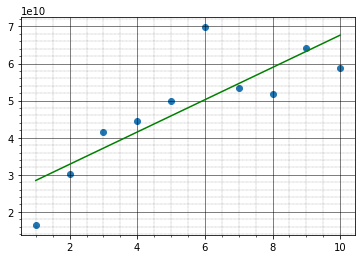

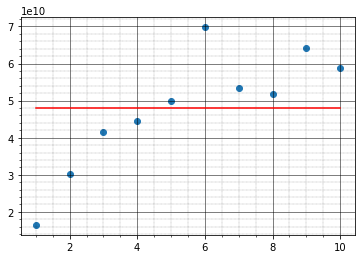

2.2705301748999997e+21
The rsquared value is: 0.6886151308154063


In [31]:
# # creating OLS regression


r2_table_FCF = pd.DataFrame()
r2_table_FCF['y'] = work_table['freeCashFlow'].replace(np.nan, 0).replace('', 0, regex=True)
r2_table_FCF['x'] = work_table['year_index']

print(r2_table_FCF)

slope, intercept, r_value, p_value, std_err = stats.linregress(r2_table_FCF['x'], r2_table_FCF['y'])


def linefitline(b):
    return intercept + slope * b


# line1 = linefitline(r2_table['x'])
line1 = linefitline(r2_table_FCF['x'])

# plot line
plt.scatter(r2_table_FCF['x'], r2_table_FCF['y'])
plt.plot(r2_table_FCF['x'], line1, c='g')
plt.grid(color='black', which='major', linewidth=0.5)
plt.minorticks_on()
plt.grid(color='black', linestyle = ':', linewidth=0.3, which='minor')
plt.show()

line2 = np.full(10, [r2_table_FCF['y'].mean()])
plt.scatter(r2_table_FCF['x'], r2_table_FCF['y'])
plt.plot(r2_table_FCF['x'], line2, c='r')
plt.grid(color='black', which='major', linewidth=0.5)
plt.minorticks_on()
plt.grid(color='black', linestyle = ':', linewidth=0.3, which='minor')
plt.show()

differences_line1 = linefitline(r2_table_FCF['x']) - r2_table_FCF['y']
line1sum = 0
for k in differences_line1:
    line1sum = line1sum + (k * k)

differences_line2 = line2 - r2_table_FCF['y']
line2sum = 0
for k in differences_line2:
    line2sum = line2sum + (k * k)

print(line2sum)

r2_FCF = r2_score(r2_table_FCF['y'], linefitline(r2_table_FCF['x']))
print('The rsquared value is: ' + str(r2_FCF))

### Анализ эмоциональной окраски новостей о компании

In [32]:
news_tables = {}
tickers = [COMPANY]

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [33]:
# Read one single day of headlines for 'AMZN' 
news = news_tables[COMPANY]
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
news_tr = news.findAll('tr')

for i, table_row in enumerate(news_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 7:
        break

Should you be buying a second-hand smartphone?
Oct-02-20 04:52AM  
Why Google Play Is Changing Its Payment Policy
Oct-01-20 06:47PM  
'Dangerous for democracy': Big Tech hearing gives clues on future of antitrust law
06:41PM  
House Antitrust Chair Says Big Tech Abuses Gatekeeper Power
06:34PM  
Goldman Sachs Is Buying General Motors Credit-Card Business. Heres Why.
06:34PM  
Apple iPhone Sales Could Get Lift As Huawei Smartphone Production Stalls
04:40PM  
Apple Inc. stock rises Thursday, still underperforms market
04:25PM  
Dow Jones Pares Gains As Coronavirus Relief Hopes Fade; These Stocks Break Out
03:17PM  


In [34]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['AAPL',
  'Oct-02-20',
  '04:52AM',
  'Should you be buying a second-hand smartphone?'],
 ['AAPL',
  'Oct-01-20',
  '06:47PM',
  'Why Google Play Is Changing Its Payment Policy'],
 ['AAPL',
  'Oct-01-20',
  '06:41PM',
  "'Dangerous for democracy': Big Tech hearing gives clues on future of antitrust law"],
 ['AAPL',
  'Oct-01-20',
  '06:34PM',
  'House Antitrust Chair Says Big Tech Abuses Gatekeeper Power'],
 ['AAPL',
  'Oct-01-20',
  '06:34PM',
  'Goldman Sachs Is Buying General Motors Credit-Card Business. Heres Why.'],
 ['AAPL',
  'Oct-01-20',
  '04:40PM',
  'Apple iPhone Sales Could Get Lift As Huawei Smartphone Production Stalls'],
 ['AAPL',
  'Oct-01-20',
  '04:25PM',
  'Apple Inc. stock rises Thursday, still underperforms market'],
 ['AAPL',
  'Oct-01-20',
  '03:17PM',
  'Dow Jones Pares Gains As Coronavirus Relief Hopes Fade; These Stocks Break Out'],
 ['AAPL', 'Oct-01-20', '03:03PM', '3 Stocks Peter Lynch Would Love'],
 ['AAPL',
  'Oct-01-20',
  '02:03PM',
  'Heres where Bide

In [35]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AAPL,2020-10-02,04:52AM,Should you be buying a second-hand smartphone?,0.000,1.000,0.000,0.0000
1,AAPL,2020-10-01,06:47PM,Why Google Play Is Changing Its Payment Policy,0.000,0.745,0.255,0.3400
2,AAPL,2020-10-01,06:41PM,'Dangerous for democracy': Big Tech hearing gi...,0.205,0.795,0.000,-0.4767
3,AAPL,2020-10-01,06:34PM,House Antitrust Chair Says Big Tech Abuses Gat...,0.310,0.690,0.000,-0.5574
4,AAPL,2020-10-01,06:34PM,Goldman Sachs Is Buying General Motors Credit-...,0.000,1.000,0.000,0.0000


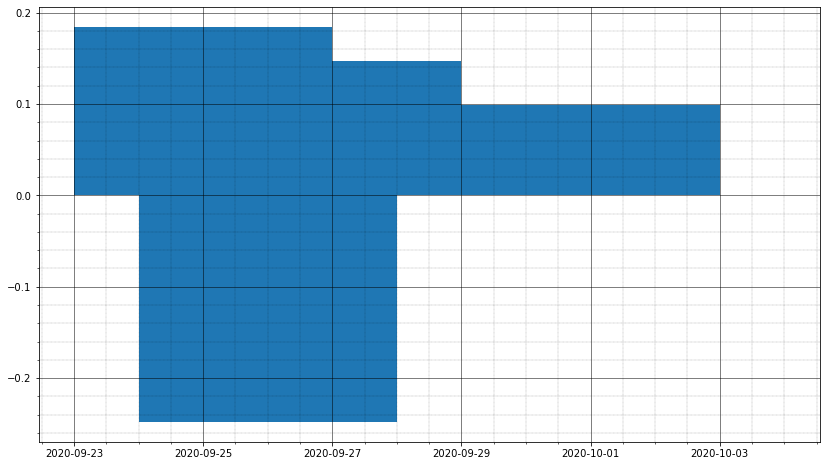

In [36]:
plt.rcParams['figure.figsize'] = [14, 8]
# # Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# # Unstack the column ticker
mean_scores = mean_scores.unstack()
# # Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# # Plot a bar chart with pandas
# mean_scores.plot(kind = 'bar')
# plt.grid()

fig, ax = plt.subplots()

ax.bar(mean_scores.index, mean_scores[f'{COMPANY}'], width = 4 )

plt.grid(color='black', which='major', linewidth=0.5)
plt.minorticks_on()
plt.grid(color='black', linestyle = ':', linewidth=0.3, which='minor')
plt.show()




In [37]:
print(work_table['interestExpense'])

0    3.576000e+09
1    3.240000e+09
2    2.323000e+09
3    1.456000e+09
4    7.330000e+08
5    3.840000e+08
6    1.360000e+08
7    1.088000e+09
8    5.190000e+08
9    3.110000e+08
Name: interestExpense, dtype: float64


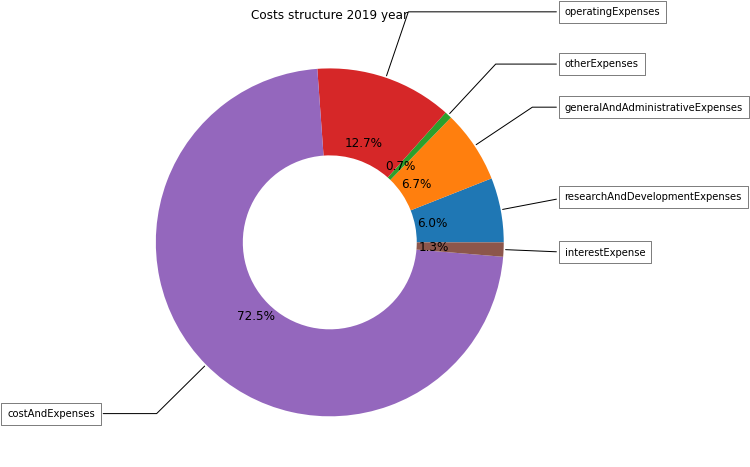

In [38]:
import matplotlib.pyplot as plotter

plot_data = []
labels = []

costs_structure = [
                    work_table['researchAndDevelopmentExpenses'][0], work_table['generalAndAdministrativeExpenses'][0]
                  , work_table['sellingAndMarketingExpenses'][0], work_table['otherExpenses'][0]
                   , work_table['operatingExpenses'][0], work_table['costAndExpenses'][0]
                   , work_table['interestExpense'][0]                  
                  ]


pieLabels =  [
                   'researchAndDevelopmentExpenses', 'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses'
                    ,'otherExpenses', 'operatingExpenses', 'costAndExpenses', 'interestExpense'                
                  ]


for structure, labelzzz in zip( costs_structure, pieLabels):
    if structure > 0:
        plot_data.append(structure)
        labels.append(labelzzz)


fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))



def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)

wedges, texts, autotexts = ax.pie(plot_data, autopct=lambda pct: func(pct, plot_data), 
                                  wedgeprops=dict(width=0.5), startangle=0.0)

bbox_props = dict(boxstyle="square,pad=0.6", fc="w", ec="k", lw=0.5)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Costs structure 2019 year")
plt.setp(autotexts, size=12)


plt.show()



# fig, axes = plt.subplots(2, 2, figsize=(30,30), sharey='row')

# i = 0
# for row in range(2):
#     for column in range(2):
#         axes[row, column].pie([
#                     work_table['researchAndDevelopmentExpenses'][i], work_table['generalAndAdministrativeExpenses'][i]
#                   , work_table['sellingAndMarketingExpenses'][i], work_table['otherExpenses'][i]
#                    , work_table['operatingExpenses'][i], work_table['costAndExpenses'][i]
#                    , work_table['interestExpense'][i]                  
#                   ], labels=pieLabels, autopct='%9.2f',  startangle=0.0)
#         axes[row, column].set_title(f'''Costs structure {2019 - i} year ''')
# #         axes[row, column].grid()
# #         axes[row, column].set_xticks(dates)
# #         axes[row, column].set_xticklabels(dates_ticks, rotation=90)

#         i += 1

# plt.show()